# Breast Cancer Analysis with Logistic Regression and RBF Network

In [226]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rbf
import importlib
from math import sqrt

In [227]:
# Load the breast cancer dataset
data = load_breast_cancer()

# Convert to pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = (data.target == 0).astype(int)  # Binary target: 0 (malignant) -> 1, 1 (benign) -> 0

# Split the dataset into 70% training and 30% testing
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Optionally, convert back to DataFrame after scaling
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.shape

(398, 30)

## Logistic regression on the original dataset

In [228]:
# Perform logistic regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Compute the accuracy of the model
y_pred = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.96


/Users/guilhermejose/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [229]:
# Compute the confusion matrix and recall
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')
print(f'Recall: {(tp / (tp + fn)):.2f}')


True negatives: 103
False positives: 5
False negatives: 2
True positives: 61
Recall: 0.97


In [230]:
# Perform EM clustering, compute the silhouette score and store it
em_models = []
silhouettes = []
for k in range(2, 20):
    gmm = GaussianMixture(n_components=k, random_state=0)
    gmm.fit(X_train)
    y_pred = gmm.predict(X_test)
    score = silhouette_score(X_test, y_pred)
    silhouettes.append(score)
    em_models.append(gmm)


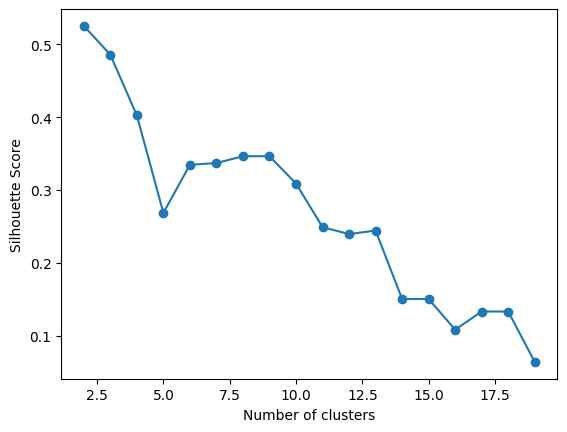

In [231]:
# Plot the silhouette results

plt.plot(range(2, 20), silhouettes, marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [232]:
for i, score in enumerate(silhouettes):
    print(f'k = {i + 2}, Silhouette Score: {score:.2f}')

k = 2, Silhouette Score: 0.52
k = 3, Silhouette Score: 0.49
k = 4, Silhouette Score: 0.40
k = 5, Silhouette Score: 0.27
k = 6, Silhouette Score: 0.33
k = 7, Silhouette Score: 0.34
k = 8, Silhouette Score: 0.35
k = 9, Silhouette Score: 0.35
k = 10, Silhouette Score: 0.31
k = 11, Silhouette Score: 0.25
k = 12, Silhouette Score: 0.24
k = 13, Silhouette Score: 0.24
k = 14, Silhouette Score: 0.15
k = 15, Silhouette Score: 0.15
k = 16, Silhouette Score: 0.11
k = 17, Silhouette Score: 0.13
k = 18, Silhouette Score: 0.13
k = 19, Silhouette Score: 0.06


The number of clusters with the highest silhouette aligns perfectly with the problem. With a binary target variable we got k = 2 as the optimal number of clusters.

## Transforming the Data for Different k Values

In this step, we trasform the data into probability values for each cluster. We will make several transformations for different values of __k__. Then we store the transformed dataset to later use.

In [233]:
# For different k values, transform and store the data
X_train_transformed = []
X_test_transformed = []
for em_model in em_models:
    X_train_transformed.append(em_model.predict_proba(X_train))
    X_test_transformed.append(em_model.predict_proba(X_test))

Here we apply logistic regression for each of the transformed dataset and then store it.

## Classifying patients based on the cluster probabilities
Here, we use the cluster probabilities to classify the patients.

In [234]:
# Perform logistic regression on the transformed data
accuracies = []
recalls = []

# For different k values, apply logistic regression, compute and store the accuracy and recall
for i in range(len(em_models)):
    model = LogisticRegression()
    model.fit(X_train_transformed[i], y_train)
    y_pred = model.predict(X_test_transformed[i])
    score = accuracy_score(y_test, y_pred)
    accuracies.append(score)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp / (tp + fn)
    recalls.append(recall)


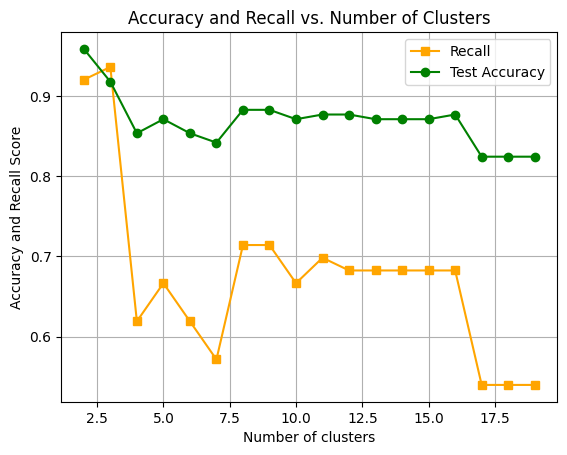

k = 2, Accuracy: 0.96, Recall: 0.92
k = 3, Accuracy: 0.92, Recall: 0.94
k = 4, Accuracy: 0.85, Recall: 0.62
k = 5, Accuracy: 0.87, Recall: 0.67
k = 6, Accuracy: 0.85, Recall: 0.62
k = 7, Accuracy: 0.84, Recall: 0.57
k = 8, Accuracy: 0.88, Recall: 0.71
k = 9, Accuracy: 0.88, Recall: 0.71
k = 10, Accuracy: 0.87, Recall: 0.67
k = 11, Accuracy: 0.88, Recall: 0.70
k = 12, Accuracy: 0.88, Recall: 0.68
k = 13, Accuracy: 0.87, Recall: 0.68
k = 14, Accuracy: 0.87, Recall: 0.68
k = 15, Accuracy: 0.87, Recall: 0.68
k = 16, Accuracy: 0.88, Recall: 0.68
k = 17, Accuracy: 0.82, Recall: 0.54
k = 18, Accuracy: 0.82, Recall: 0.54
k = 19, Accuracy: 0.82, Recall: 0.54


In [235]:
# Recall and accuracy plot
plt.plot(range(2, 20), recalls, marker='s', label='Recall', color='orange')
plt.plot(range(2, 20), accuracies, marker='o', label='Test Accuracy', color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy and Recall Score')
plt.title('Accuracy and Recall vs. Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

for i in range(len(accuracies)):
    print(f'k = {i + 2}, Accuracy: {accuracies[i]:.2f}, Recall: {recalls[i]:.2f}')

## RBF network with mapped dataset when k = 2

In [236]:
# Get the centers of cluster 1 and 2
centers = em_models[0].means_

# Sigma is the euclidean distance between the centers of the two clusters multiplied by square root of 2
sigma = sqrt(2) * np.linalg.norm(centers[0] - centers[1])

# Reload the module to get the latest changes
importlib.reload(rbf)

# Initialize and fit the model
model = rbf.RBFNetwork(centers=centers, sigma=sigma)
model.fit(X_train, y_train)

In [237]:
# Predict the test data and compute the accuracy
importlib.reload(rbf)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9005847953216374

In [238]:
# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')
print(f'Recall: {(tp / (tp + fn)):.2f}')

True negatives: 106
False positives: 2
False negatives: 15
True positives: 48
Recall: 0.76


In [239]:
accuracies = []
recalls = []
train_accuracies = []
for i, model in enumerate(em_models[1:]):
    centers = model.means_
    # sigma is the average euclidean distance between the centers of the clusters
    sigma = (np.mean([np.linalg.norm(centers[i] - centers[j]) for i in range(len(centers)) for j in range(i + 1, len(centers))]))

    model = rbf.RBFNetwork(centers=centers, sigma=sigma)
    model.fit(X_train, y_train)

    # Compute the accuracy on the test data
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Compute the recall on the test data
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    recall = tp / (tp + fn)
    recalls.append(recall)
    
    # Compute the accuracy on the training data
    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_accuracies.append(train_accuracy)


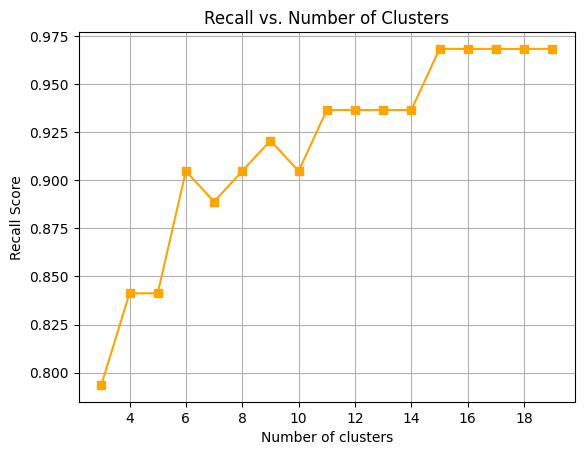

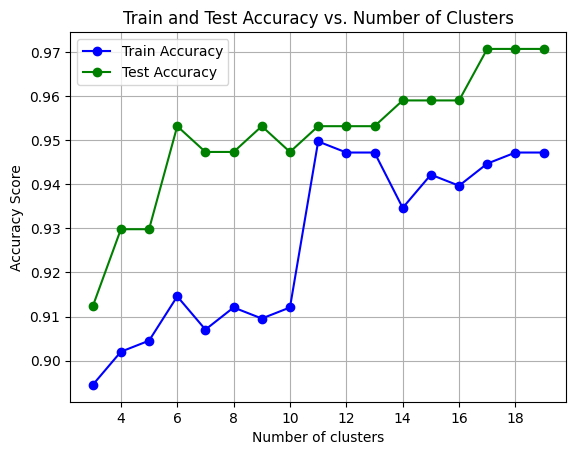

In [240]:
# Recall plot
plt.plot(range(3, 20), recalls, marker='s', label='Recall', color='orange')
plt.xlabel('Number of clusters')
plt.ylabel('Recall Score')
plt.title('Recall vs. Number of Clusters')
plt.grid(True)
plt.show()

# Train and Test Accuracy in the same plot
plt.plot(range(3, 20), train_accuracies, marker='o', label='Train Accuracy', color='blue')
plt.plot(range(3, 20), accuracies, marker='o', label='Test Accuracy', color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy Score')
plt.title('Train and Test Accuracy vs. Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()



In [241]:
for i in range(len(accuracies)):
    print(f'k = {i + 3}, Accuracy: {accuracies[i]:.2f}, Recall: {recalls[i]:.2f}')

k = 3, Accuracy: 0.91, Recall: 0.79
k = 4, Accuracy: 0.93, Recall: 0.84
k = 5, Accuracy: 0.93, Recall: 0.84
k = 6, Accuracy: 0.95, Recall: 0.90
k = 7, Accuracy: 0.95, Recall: 0.89
k = 8, Accuracy: 0.95, Recall: 0.90
k = 9, Accuracy: 0.95, Recall: 0.92
k = 10, Accuracy: 0.95, Recall: 0.90
k = 11, Accuracy: 0.95, Recall: 0.94
k = 12, Accuracy: 0.95, Recall: 0.94
k = 13, Accuracy: 0.95, Recall: 0.94
k = 14, Accuracy: 0.96, Recall: 0.94
k = 15, Accuracy: 0.96, Recall: 0.97
k = 16, Accuracy: 0.96, Recall: 0.97
k = 17, Accuracy: 0.97, Recall: 0.97
k = 18, Accuracy: 0.97, Recall: 0.97
k = 19, Accuracy: 0.97, Recall: 0.97
